In [1]:
from full_system_hamiltonian import *
from get_setup import params_for_n_site_Hamiltonian
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import expm
from numba import njit, objmode
from scipy.sparse.linalg import eigsh
import time


In [2]:
n_sites = 3
dupes = 3
big_N = n_sites * dupes

pars, extras = params_for_n_site_Hamiltonian(n_sites, configs=None, specified_vals={"U": [0.1]}, path="/home/Hishem/repos/MastersThesis/configuration.json")


t, U, eps, Delta = pars

print("t, U, eps, Delta =", t, U, eps, Delta)

t_couple = t 
delta_couple = Delta


t: [1. 1.]
U: [0.1 0.1]
eps: [-0.10097739030086553, -0.6071436946690216, -0.0032830574591187892]
Delta: [1.001265238594651, 1.0015039227972797]
t, U, eps, Delta = [1. 1.] [0.1 0.1] [-0.10097739030086553, -0.6071436946690216, -0.0032830574591187892] [1.001265238594651, 1.0015039227972797]


In [3]:
operators = {}
cre, ann, num = precompute_ops(big_N)
operators['cre'] = cre
operators['ann'] = ann
operators['num'] = num
hop_ops = {}
pair_ops = {}
dens_ops = {}
for i in range(big_N):
    for j in range(i+1, big_N):
        hop_ops[(i,j)] = cre[i] @ ann[j] + ann[i] @ cre[j]
        pair_ops[(i,j)] = cre[i] @ cre[j] + ann[j] @ ann[i]
        dens_ops[(i,j)] = num[i] @ num[j]
operators['hop'] = hop_ops
operators['pair'] = pair_ops
operators['dens'] = dens_ops



In [4]:
def simple_delta_pulse(t, T_peak, width, s, max_val,min_val):
    T_start = T_peak - width / 2
    T_end = T_peak + width / 2

    rise = 1/(1 + np.exp(-s*(t - T_start)))
    fall = 1/(1 + np.exp(s*(t - T_end)))

    return min_val + (max_val - min_val) * rise * fall


In [5]:
def hamiltonian(n, dup, t_vals, U_vals, eps_vals, delta_vals,
               couplings=(), eps_detune=None, operators=None):

    big_N = dup * n
    dim = 2**big_N
    H = np.zeros((dim, dim), dtype=complex)

    if operators is None:
        cre, ann, num = precompute_ops(big_N)
        hop_ops = {}
        pair_ops = {}
        dens_ops = {}
        for i in range(big_N):
            for j in range(i+1, big_N):
                hop_ops[(i,j)] = cre[i] @ ann[j] + ann[i] @ cre[j]
                pair_ops[(i,j)] = cre[i] @ cre[j] + ann[j] @ ann[i]
                dens_ops[(i,j)] = num[i] @ num[j]
    else:
        cre = operators["cre"]
        ann = operators["ann"]
        num = operators["num"]
        hop_ops = operators["hop"]
        pair_ops = operators["pair"]
        dens_ops = operators["dens"]
    # cre, ann, num = precompute_ops(big_N)

    eps_full = np.tile(eps_vals, (dup,1))
    if eps_detune:
        for i in range(len(eps_detune)):
            # print(len(eps_detune))
            eps_dict = eps_detune[i]
            # print(eps_dict)
            site_idx = eps_dict["site_idxs"]
            node_idx = eps_dict["node_idxs"]
            val = eps_dict["vals"]
            # print(site_idx, node_idx, val)
            eps_full[site_idx, node_idx] = val
        # for pm_idx, val in eps_detune.items():
            # eps_full[pm_idx, 0], eps_full[pm_idx, -1] = val, val


    # Intra PMM terms
    for d in range(dup):
        off = d * n
        for j in range(n-1):
            i, k = off+j, off+j+1
            H += -t_vals[j]   * hop_ops[(i,k)]
            H +=  delta_vals[j] * pair_ops[(i,k)]
            H +=  U_vals[j]   * dens_ops[(i,k)]

        for j in range(n):
            H += eps_full[d,j] * num[off+j]


    #  Inter PMM couplings
    # print("Couplings:", couplings)
    for cA, cB, t_c, d_c in couplings:
        if cA is None or cB is None:
            continue

        i = cA[0]*n + cA[1]
        j = cB[0]*n + cB[1]
        key = (min(i,j), max(i,j))

        if t_c != 0:
            H += -t_c * hop_ops[key]
        if d_c != 0:
            H +=  d_c * pair_ops[key]
    return H


In [6]:
AB_coupling = [(0,2), (1,0), 0.0, 0.0]
BC_coupling = [(1,0), (2,0), 0.0, 0.0]
CA_coupling = [(2,0), (0,2), 0.0, 0.0]

couplings = [
    AB_coupling,
    BC_coupling,
    CA_coupling
]

# eps_detune = None#{1: 0.0}
eps_detune = [{"site_idxs": [0], "node_idxs": [0], "vals": [0.0]}]
H = hamiltonian(n_sites, dupes, t, U, eps, Delta, couplings=couplings, eps_detune=eps_detune, operators=operators)


eigvals, eigvecs = np.linalg.eigh(H)
print(eigvals[:10])

[-6.92427719 -6.92418327 -6.92418327 -6.92408934 -6.92126996 -6.92117603
 -6.92117603 -6.92108211 -5.1589949  -5.1589949 ]


In [7]:
import time
def time_evolution(Total_time, n_steps, params, t_coup_max, Delta_coup_max, eps_detune_max, operators, lower_bound=10):
    t_val, U_val, eps_val, Delta_val = params

    tJ, dJ = t_coup_max, Delta_coup_max
    A = 0
    B = 1
    C = 2
    inner = 0 #inner node idx
    outer = 2 #outer node idx
    junction_mode = [
    ((A,inner), (B,inner), tJ, dJ),
    ((B,inner), (C,inner), tJ, dJ),
    ((C,inner), (A,inner), tJ, dJ),
    ]

    width = Total_time / 3
    s = 20/width#Total_time * 6

    time_array = np.linspace(0, Total_time, n_steps)
    dt = time_array[1] - time_array[0]


    epsilons = []
    for t in time_array:
        eps_A = simple_delta_pulse(t, 0, width, s, eps_detune_max , 0) + simple_delta_pulse(t, Total_time, width, s, eps_detune_max , 0)
        eps_B = simple_delta_pulse(t, Total_time/3, width, s, eps_detune_max , 0)
        eps_C = simple_delta_pulse(t, 2*Total_time/3, width, s, eps_detune_max , 0)

        epsilons.append([
            {"site_idxs": [A], "node_idxs": [outer], "vals": [eps_A]},
            {"site_idxs": [B], "node_idxs": [outer], "vals": [eps_B]},
            {"site_idxs": [C], "node_idxs": [outer], "vals": [eps_C]},
        ])

    pulse_info = {
 
        "epsA": [epsilons[i][0]["vals"] for i in range(len(epsilons))],
        "epsB": [epsilons[i][1]["vals"] for i in range(len(epsilons))],
        "epsC": [epsilons[i][2]["vals"] for i in range(len(epsilons))]
    }
    
    eigvals = np.zeros((n_steps, lower_bound))
    eigvecs = np.zeros((n_steps, int(2**big_N), lower_bound), dtype=complex)
    # Time Evolution


    for i in tqdm(range(len(time_array))):
        H_t = hamiltonian(n_sites, dupes, t_val, U_val, eps_val, Delta_val, couplings=junction_mode, eps_detune=epsilons[i], operators=operators)
        vals, vecs = np.linalg.eigh(H_t)
        eigvals[i,:] = vals[:lower_bound]
        eigvecs[i,:,:] = vecs[:,:lower_bound]
        exit()



    return eigvals, eigvecs, time_array, pulse_info


In [ ]:
T_total = 300
n_steps = 1000
t_coup_max = 0.5#t_couple[0]/10
Delta_coup_max = 0.5#delta_couple[0]/10
eps_detune_max = 0.8
lower_bound = 8


eigvals, eigvecs, time_array, coupling_pulses = time_evolution(T_total, n_steps, pars, t_coup_max, Delta_coup_max, eps_detune_max, operators, lower_bound=lower_bound)


100%|██████████| 1000/1000 [01:32<00:00, 10.81it/s]


: 

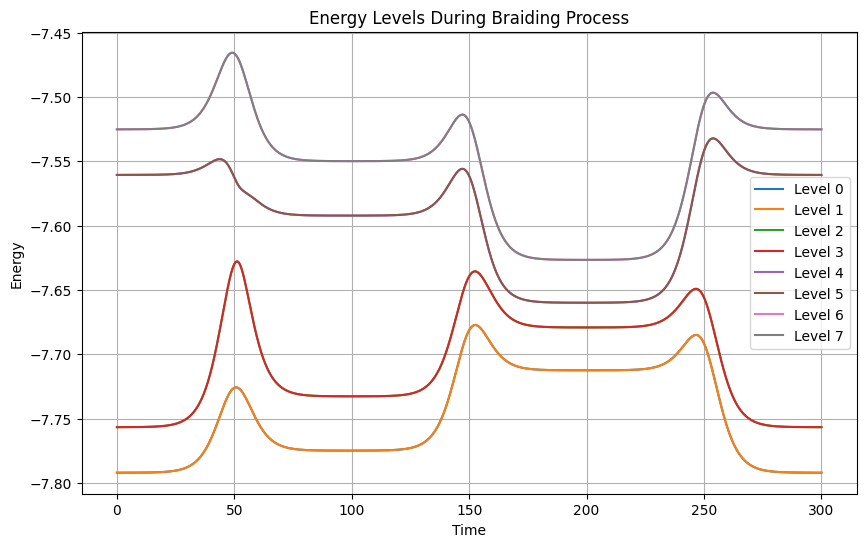

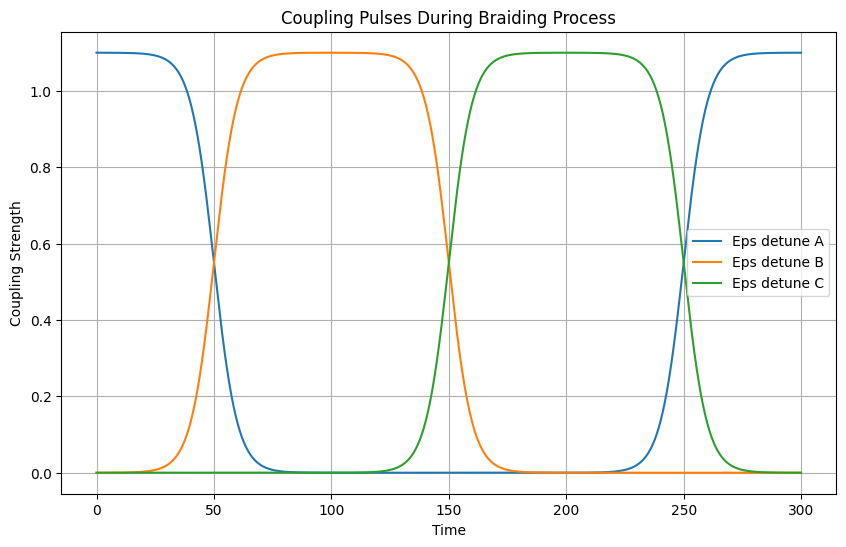

In [ ]:

plt.figure(figsize=(10,6))
for i in range(lower_bound):
    plt.plot(time_array, eigvals[:,i], label=f"Level {i}")
    # plt.show()
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy Levels During Braiding Process")
plt.legend()
plt.grid()
plt.show()  

#plot coupling pulses
plt.figure(figsize=(10,6))

epsilonA = coupling_pulses["epsA"]
epsilonB = coupling_pulses["epsB"]
epsilonC = coupling_pulses["epsC"]


plt.plot(time_array, epsilonA, label="Eps detune A")
plt.plot(time_array, epsilonB, label="Eps detune B")
plt.plot(time_array, epsilonC, label="Eps detune C")

plt.xlabel("Time")
plt.ylabel("Coupling Strength")
plt.title("Coupling Pulses During Braiding Process")
plt.legend()
plt.grid()
plt.show()

In [ ]:
def majorana_operators(n):
    create, annihilate, number = precompute_ops(n)
    majorana_ops = []
    for j in range(n):
        f_dag = create[j]
        f = annihilate[j]
        gamma_1 = f + f_dag
        gamma_2 = -1j * (f - f_dag)
        majorana_ops.append((gamma_1, gamma_2))
    return majorana_ops


def majorana_correlation_matrix(rho, gammas):
    n = len(gammas)
    C = np.zeros((n, n))

    for a in range(n):
        for b in range(n):
            C[a, b] = np.trace(rho @ gammas[a] @ gammas[b]).imag

    return 0.5 * (C - C.T)

num_ops = operators['num']
P = total_parity(num_ops)   # operator, time-independent

Cs = []
t = 0   


for t in [0, int(T_total // 3), int(2 * T_total // 3), int(T_total) ]:

    eigvecs_t = eigvecs[t]     # shape (dim, n_states)
    eigvals_t = eigvals[t]

    # --- parity expectation for instantaneous eigenstates ---
    parities = np.array([
        np.vdot(eigvecs_t[:, k], P @ eigvecs_t[:, k]).real
        for k in range(eigvecs_t.shape[1])
    ])

    # --- select even-parity LOW-ENERGY states ---
    even_states = [k for k in range(len(parities)) if parities[k] > 0.9]

    K = min(lower_bound, len(even_states))
    selected = even_states[:K]

    rho = sum(
        np.outer(eigvecs_t[:, k], eigvecs_t[:, k].conj())
        for k in selected
    ) / K

    gammas = [g for pair in majorana_operators(big_N) for g in pair]
    C = majorana_correlation_matrix(rho, gammas)
    Cs.append(C)

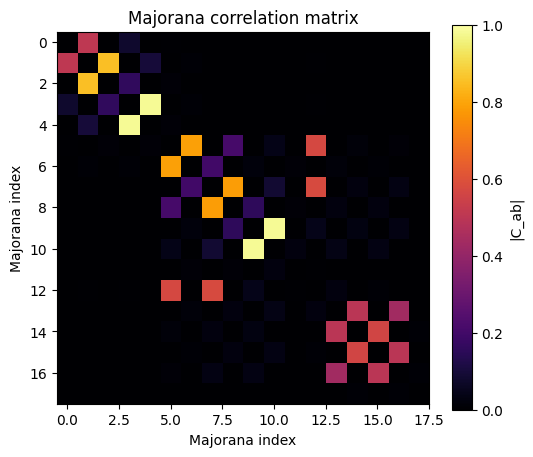

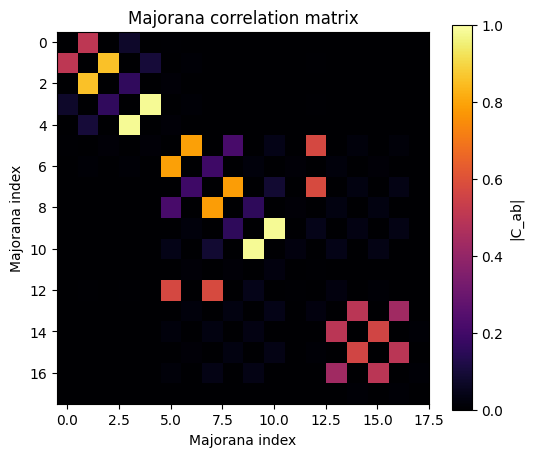

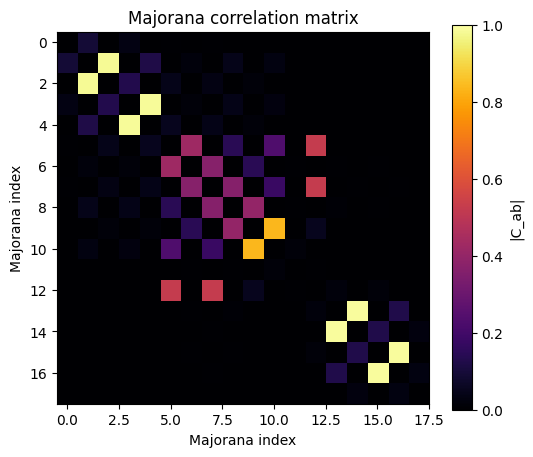

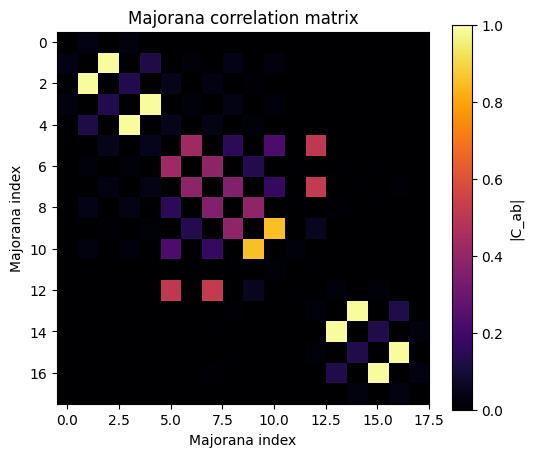

In [ ]:
for idx, C in enumerate(Cs):
    plt.figure(figsize=(6,5))
    plt.imshow(np.abs(C), cmap='inferno', vmax=1)
    plt.colorbar(label='|C_ab|')
    plt.title('Majorana correlation matrix')
    plt.xlabel('Majorana index')
    plt.ylabel('Majorana index')
    plt.show()

## Savings

In [ ]:
# H = big_H(n_sites, dupes, t, U, eps, Delta, couplings=couplings, eps_detune=eps_detune, operators=operators)

# ordered_couplings = {
#     "AB": {
#         "idx0": (0,2),
#         "idx1": (1,0),
#         "t_coup": None,
#         "Delta_coup": None
#     },
#     "eps_detune": None,
#     "BC": {
#         "idx0": (1,0),
#         "idx1": (2,0),
#         "t_coup": None,
#         "Delta_coup": None
#     },
# }


# def time_evolve(Total_time, n_steps, params, t_coup_max, Delta_coup_max, eps_detune_max, ordered_couplings, operators, lower_bound=10):

    
#     t_val, U_val, eps_val, Delta_val = params

#     couplings = []
#     eps_detune = {}
#     OC = ordered_couplings
#     for i in range(len(OC)): 
#         key = list(OC.keys())[i]
        
#         current = OC[key]
#         print(current)
#         if key == "eps_detune":
#             if current is not None:
#                 eps_detune = current
#             else: 
#                 eps_detune = {1: eps_detune_max}
#         else:
#             if current['t_coup'] is None:
#                 current['t_coup'] = t_coup_max
#             if current['Delta_coup'] is None:
#                 current['Delta_coup'] = Delta_coup_max
#             couplings.append([current['idx0'], current['idx1'], current['t_coup'], current['Delta_coup']])

#     print("Couplings for time evolution:", couplings)
#     print("Eps detune for time evolution:", eps_detune)


#     #Create Coupling pulse arrays:
#     time_array = np.linspace(0, Total_time, n_steps)
#     dt = time_array[1] - time_array[0]
#     ##Order of pulses AB peak at T=0 and T=Total_time, Eps Detune at T=Total_time/3, BC at T=2*Total_time/3
#     AB_t_peaks = [Total_time/3]#[0, Total_time]
#     BC_t_peaks = [2*Total_time/3]
#     eps_t_peaks = [0, Total_time]#[Total_time/3]

#     width = Total_time / 3
#     s = 20/width#Total_time * 6

#     All_Couplings = []
#     epsilons = []

#     # Precompute the pulses
#     for t in time_array:

#         eps_detune_val = simple_delta_pulse(t, eps_t_peaks[0], width, s, eps_detune_max , 0) + simple_delta_pulse(t, eps_t_peaks[1], width, s, eps_detune_max , 0)
#         epsilons.append(eps_detune_val)
        
#         current_couplings = []
#         for i,coup in enumerate(couplings):
#             # print(i, coup)
#             if i == 0:
#                 curr_t = simple_delta_pulse(t, AB_t_peaks[0], width, s, coup[2] , 0)# + simple_delta_pulse(t, AB_t_peaks[1], width, s, coup[2] , 0)
#                 curr_delta = simple_delta_pulse(t, AB_t_peaks[0], width, s, coup[3] , 0)# + simple_delta_pulse(t, AB_t_peaks[1], width, s, coup[3] , 0)
                
#                 current_coupling = [coup[0], coup[1], curr_t, curr_delta]
#                 current_couplings.append(current_coupling)
#             else:
#                 curr_t = simple_delta_pulse(t, BC_t_peaks[0], width, s, coup[2] , 0)
#                 curr_delta = simple_delta_pulse(t, BC_t_peaks[0], width, s, coup[3] , 0)
                
#                 current_coupling = [coup[0], coup[1], curr_t, curr_delta]
#                 current_couplings.append(current_coupling)

#         All_Couplings.append(current_couplings)
    

#     coupling_pulses = {
#         "AB_coupling": [All_Couplings[i][0] for i in range(len(All_Couplings))],
#         "BC_coupling": [All_Couplings[i][1] for i in range(len(All_Couplings))],
#         "eps_detune": epsilons
#     }

#     eigvals = np.zeros((n_steps, lower_bound))
#     eigvecs = np.zeros((n_steps, int(2**big_N), lower_bound), dtype=complex)
#     # Time Evolution
#     tJ = t_coup_max
#     dJ = Delta_coup_max
#     A = 0
#     B = 1
#     C = 2
#     gamma0_coupling = couplings = [
#     ((A,2), (B,0), tJ, dJ),
#     ((B,0), (C,0), tJ, dJ),
#     ((C,0), (A,2), tJ, dJ),
#     ]
#     #For each time step in ALL couplings, append gamma0coupling as well
#     for i in range(len(All_Couplings)):
#         for coup in gamma0_coupling:
#             All_Couplings[i].append(coup)
    
#     print(All_Couplings[0])

#     for i in tqdm(range(len(time_array))):
#         # H_t = big_H(n_sites, dupes, t_val, U_val, eps_val, Delta_val, couplings=All_Couplings[i], eps_detune={1: epsilons[i]}, operators=operators)
#         H_t = big_H(n_sites, dupes, t_val, U_val, eps_val, Delta_val, couplings=All_Couplings[i], eps_detune=0, operators=operators)
#         vals, vecs = np.linalg.eigh(H_t)
#         eigvals[i,:] = vals[:lower_bound]
#         eigvecs[i,:,:] = vecs[:,:lower_bound]

    
#     return eigvals, eigvecs, time_array, coupling_pulses
# T_total = 300
# n_steps = 1000
# t_coup_max = t_couple[0]/10
# Delta_coup_max = delta_couple[0]/10
# eps_detune_max = 1/10
# lower_bound = 8


# eigvals, eigvecs, time_array, coupling_pulses = time_evolve(T_total, n_steps, pars, t_coup_max, Delta_coup_max, eps_detune_max, ordered_couplings, operators, lower_bound=lower_bound)


def time_evolution(Total_time, n_steps, params, t_coup_max, Delta_coup_max, eps_detune_max, operators, lower_bound=10):
    print("Hei")
    t_val, U_val, eps_val, Delta_val = params

    tJ, dJ = t_coup_max, Delta_coup_max
    A = 0
    B = 1
    C = 2
    junction_mode = [
    ((A,2), (B,0), tJ, dJ),
    ((B,0), (C,0), tJ, dJ),
    ((C,0), (A,2), tJ, dJ),
    ]

    width = Total_time / 3
    s = 20/width#Total_time * 6

    time_array = np.linspace(0, Total_time, n_steps)
    dt = time_array[1] - time_array[0]

    eps_A_dict = {"site_idxs": [A], "node_idxs": [0], "vals": [0.0]}
    eps_B_dict = {"site_idxs": [B], "node_idxs": [2], "vals": [0.0]}
    eps_C_dict = {"site_idxs": [C], "node_idxs": [2], "vals": [0.0]}


    All_Couplings = []
    epsilons = []
    for t in time_array:
        eps_A = simple_delta_pulse(t, 0, width, s, eps_detune_max , 0) + simple_delta_pulse(t, Total_time, width, s, eps_detune_max , 0)
        eps_B = simple_delta_pulse(t, Total_time/3, width, s, eps_detune_max , 0)
        eps_C = simple_delta_pulse(t, 2*Total_time/3, width, s, eps_detune_max , 0)

        eps_A_dict["vals"] = [eps_A]
        eps_B_dict["vals"] = [eps_B]
        eps_C_dict["vals"] = [eps_C]
        epsilons.append([eps_A_dict, eps_B_dict, eps_C_dict])




        # AB_coup_t = simple_delta_pulse(t, 0, width, s, t_coup_max , 0) + simple_delta_pulse(t, Total_time, width, s, t_coup_max , 0)
        # AB_delta_t = simple_delta_pulse(t, 0, width, s, Delta_coup_max , 0) + simple_delta_pulse(t, Total_time, width, s, Delta_coup_max , 0)

        # BC_coup_t = simple_delta_pulse(t, Total_time/3, width, s, t_coup_max , 0)
        # BC_delta_t = simple_delta_pulse(t, Total_time/3, width, s, Delta_coup_max , 0)   

        # current_couplings = [
        #     ((A,2), (B,0), AB_coup_t, AB_delta_t),
        #     ((B,0), (C,0), BC_coup_t, BC_delta_t),
        # ]
        # junction mode
        # if t < Total_time / 3:
        #     current_couplings.append(junction_mode[0])
        # elif t < 2 * Total_time / 3:
        #     current_couplings.append(junction_mode[1])
        # else:
        #     current_couplings.append(junction_mode[2])

        # All_Couplings.append(current_couplings)
    
    pulse_info = {
        # "AB_coupling": [All_Couplings[i][0] for i in range(len(All_Couplings))],
        # "BC_coupling": [All_Couplings[i][1] for i in range(len(All_Couplings))],
        # "eps_detune": epsilons
        "epsA": [epsilons[i][0]["vals"] for i in range(len(epsilons))],
        "epsB": [epsilons[i][1]["vals"] for i in range(len(epsilons))],
        "epsC": [epsilons[i][2]["vals"] for i in range(len(epsilons))]
    }
    
    eigvals = np.zeros((n_steps, lower_bound))
    eigvecs = np.zeros((n_steps, int(2**big_N), lower_bound), dtype=complex)
    # Time Evolution
    for i in tqdm(range(len(time_array))):
        H_t = hamiltonian(n_sites, dupes, t_val, U_val, eps_val, Delta_val, couplings=junction_mode, eps_detune=epsilons[i], operators=operators)
        vals, vecs = np.linalg.eigh(H_t)
        eigvals[i,:] = vals[:lower_bound]
        eigvecs[i,:,:] = vecs[:,:lower_bound]

    return eigvals, eigvecs, time_array, pulse_info




